In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Read the data and basic understanding of it

In [2]:
df=pd.read_excel("Recruitment x Good Food Challenge x Q1 2019.xlsx")


In [2]:
df2=pd.read_excel("Recruitment x Good Food Challenge x Q1 2019.xlsx",1)

In [3]:
df2.shape

(17949, 5)

In [71]:
df.shape

(1335, 33)

In [5]:
xl=pd.ExcelFile("Recruitment x Good Food Challenge x Q1 2019.xlsx")
xl.sheet_names

['Recipe Data', 'Reviews']

Let's first start with seeing what the columns are:

In [3]:
df.columns

Index(['Recipe Url', 'Recipe Name', 'Preparation Time', 'Cooking Time',
       'Difficulty', 'Serves', 'Nutritional Info', 'Ingredients', 'Steps',
       'Additional Tags'],
      dtype='object')

From the column names we can guess which ones we need to dig deeper.
For example here, the column <font color='red'>'Ingredients'</font> will provide us an important metric about the amount of cheese used in a particular recipe.
But let's first take a look into few rows to understand better 

In [4]:
df.head()

,Recipe Url,Recipe Name,Preparation Time,Cooking Time,Difficulty,Serves,Nutritional Info,Ingredients,Steps,Additional Tags
0,https://www.bbcgoodfood.com/recipes/470640/car...,Carrot & cream cheese cupcakes,30 mins,22 mins,Easy,Makes 12,"{'kcal':'442','sugars':'26g','salt':'0.7g','ca...","['175g light muscovado sugar','100g wholemeal ...",{'1':'Heat oven to 180C/160C fan/gas 4 and lin...,['Can be frozen un-iced']
1,https://www.bbcgoodfood.com/recipes/358608/cau...,Cauliflower cheese,10 mins,35 mins,Easy,6,"{'kcal':'250','sugars':'8g','salt':'0.62g','ca...","['1 large cauliflower (leaves cut off), broken...",{'1':'Bring a large saucepan of water to the b...,['Vegetarian']
2,https://www.bbcgoodfood.com/recipes/4382/veggi...,Veggie shepherd's pie with sweet potato mash,10 mins,50 mins - 1 hr,Easy,4,"{'kcal':'540','sugars':'33g','salt':'2.39g','c...",['1 tbsp olive oil Olive oil ol-iv oyl Probabl...,"{'1':'Heat 1 tbsp olive oil in a frying pan, t...","['Freezable','Easily halved','Vegetarian']"
3,https://www.bbcgoodfood.com/recipes/3327/cauli...,Cauliflower cheese soup,10 mins,NaN,Easy,"6 adults, or 4 adults and 4 kids","{'kcal':'188','sugars':'9g','salt':'0.82g','ca...",['knob of butter Butter butt-err Butter is mad...,{'1':'Heat the butter in a large saucepan. Tip...,"['For up to 1 month, without cheese']"
4,https://www.bbcgoodfood.com/recipes/cheese-sauce,Cheese sauce,5 mins,8 mins - 10 mins,Easy,6,"{'kcal':'219','sugars':'4g','salt':'0.54g','ca...",['500ml milk Milk mill-k One of the most widel...,{'1':'Pour 500ml milk into a large saucepan an...,['Vegetarian']


# Extracting Cheese quantity

Upon carefully looking at the ingredients column, we can see that we can extract the Cheese quantity from the list of ingredients.
We further seperate it into 3 columns of <font color="red">Parmesan</font>, <font color="blue">Cheddar</font>, <font color="green">All Other</font>

In [5]:

def formatCheese(ingred):
    ingred1=ingred.lower()
    ingred=ingred1.split(',')
    cheese=['parmesan','cheddar','cheese','mozarella','feta']
    d={'parmesan':0,'cheddar':0,'cheese':0}
    for i in ingred:
        if 'parmesan' in i:
            try:
                d['parmesan']+=int(re.findall('[0-9][0-9]*g',i)[0][:-1])
            except:
                try:
                    d['parmesan']+=int(re.findall('[0-9][0-9]* tbsp',i)[0][:-5])*5
                except:    
                    continue
            continue
        if 'cheddar' in i:
            try:
                d['cheddar']+=int(re.findall('[0-9][0-9]*g',i)[0][:-1])
            except:
                try:
                    d['cheddar']+=int(re.findall('[0-9][0-9]* tbsp',i)[0][:-5])*5
                except:    
                    continue
            continue
        if 'cheese' in i or 'red leicester' in i or 'stilton' in i:
            try:
                d['cheese']+=int(re.findall('[0-9][0-9]*g',i)[0][:-1])
            except:
                try:
                    d['cheese']+=int(re.findall('[0-9][0-9]* tbsp',i)[0][:-5])*5
                except:    
                    continue
            continue
            
    if d['cheddar']+d['parmesan']+d['cheese']==0:
        if 'cheese' in ingred1 or 'cheddar' in ingred1 or 'parmesan' in ingred1 :
            d['cheese']=-1
    return d['cheddar'],d['parmesan'],d['cheese']

In [6]:
df['cheddar'],df['parmesan'],df['cheese']=zip(*df['Ingredients'].apply(lambda ingred: formatCheese(str(ingred))))

We now calculate the total cheese in each and then use buckets to classify the quantity.

<font color="red">1. Below 100gm</font>

<font color="Green">2. 100-200gm</font>

<font color="Blue">3. Above 200gm</font>

In [7]:
df['totalCheese']=df['parmesan']+df['cheddar']+df['cheese']
df=df.replace({'totalCheese': {-1: df['totalCheese'].median()}}) 
df['totalCheeseClass']=pd.cut(df['totalCheese'], [1, 100,200,700], labels=[1,2,3])

# Convert 'difficulty' to discrete integer class

The difficulty ranges from:

<font color="green">1. Easy</font>

<font color="blue">2. More Effort</font>

<font color="red">3. A challenge</font>

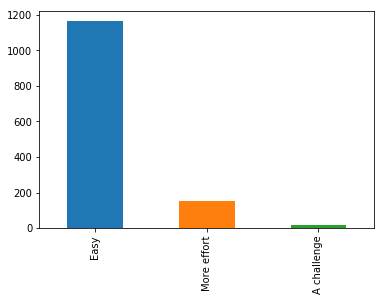

In [8]:
pd.value_counts(df['Difficulty']).plot.bar()

In [9]:
df['intDiffi']=df['Difficulty']
df=df.replace({'intDiffi': {"Easy": 1,"More effort": 2,"A challenge":3}}) 

# Difficulty vs Total Cheese

It might be interesting to see how __Amount of cheese__ changes with __Difficulty.__

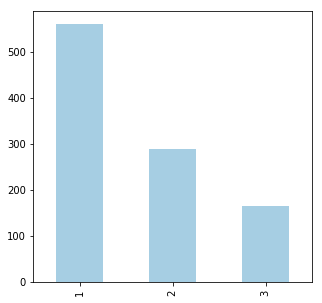

In [11]:
df[(df['intDiffi']==1) & (df['totalCheese']!=0)]['totalCheeseClass'].value_counts().plot('bar',figsize=(5,5),colormap="Paired")

# Converting Cooking and Preparation Time into mins

Initially the Cooking and Preparation time are strings.
But these can be easily formatted to get an <font color="red">integer value which represents the time in minutes.</font>

In [12]:
def prepT(s):
    s=s.split('-')
    val=0
    for t in s:
        t=t.split(',')
        for u in t:
            if 'hr' in u:
                val+=int(u.replace('hr','').replace('s','').strip(" "))*60
            if 'min' in u:
                val+=int(u.replace('min','').replace('s','').strip(" "))
    
    return val/len(s)

In [13]:
df['newPrep']=df['Preparation Time'].apply(lambda pTime: prepT(str(pTime)))

In [14]:
df['newCookT']=df['Cooking Time'].apply(lambda cTime: prepT(str(cTime)))

In [15]:
df=df.replace({'newCookT': {0.00: df['newCookT'].median()}}) 
df=df.replace({'newPrep': {0.00: df['newPrep'].median()}}) 

In [16]:
df['totalTime']=df['newPrep']+df['newCookT']

In [17]:
df.totalTime.describe()

count    1335.000000
mean       48.451311
std        30.356223
min         4.500000
25%        30.000000
50%        40.000000
75%        60.000000
max       300.000000
Name: totalTime, dtype: float64

Just like __Difficulty__ and __Total Cheese__ before, <font color='red'> Total Time </font> needs to classified into categories for easier analysis.<br>__1. Below 20 mins__<br>__2. 20-30 mins__<br>__3. 30-40 mins__<br>__4. 40 mins-1 hour__<br>__5. 1-2 hour__<br>__6. Above 2 hours__<br> 

In [18]:
df['timeBucket']=pd.cut(df['totalTime'], [0, 20,30, 40,60, 120,300], labels=[1,2,3,4,5,6])
df['time_Bucket']=pd.cut(df['totalTime'], [0, 20,30, 40,60, 120,300], labels=["< 20 mins",'20-30 mins',"30-40 mins","40mins to 1 hour","1-2 hours",">2hours"])

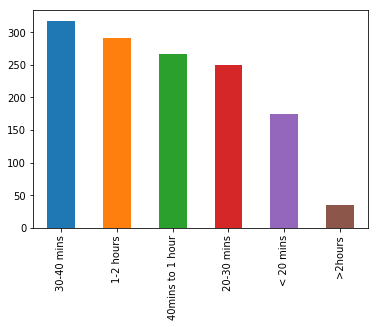

In [20]:
pd.value_counts(df['time_Bucket']).plot.bar()

# Total time vs  Total Cheese

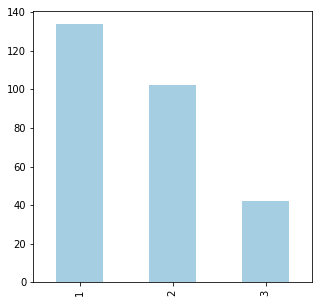

In [21]:
df[(df['timeBucket']==3) & (df['totalCheese']!=0)]['totalCheeseClass'].value_counts().plot('bar',figsize=(5,5),colormap="Paired")

# Splitting the Nutrition Info into multiple columns

The __Nutrition Info__ column has a json with mutiple nutritional values in it.<br> It might be interesting to see how __Calories, or fats, or proteins__ vary with __Difficulty, total time and amount of cheese__ 

In [22]:
def extractNut(jsonStr,colNames):
    d=ast.literal_eval(jsonStr)
    
    for key in d:
        d[key]=str(d[key])
        if key!='kcal':
            d[key]=d[key].replace('g','')
        if d[key]=='-' or d[key]=='':
            d[key]=np.nan
    return float(d['kcal']),float(d['sugars']),float(d['salt']),float(d['carbs']),float(d['protein']),float(d['fat']),float(d['fibre']),float(d['saturates'])

In [23]:
df['kcal'],df['sugars'],df['salt'],df['carbs'],df['protein'],df['fat'],df['fibre'],df['saturates']=zip(*df['Nutritional Info'].apply(lambda nut: extractNut(str(nut),'kcal')))
df['kcal']=df['kcal'].fillna(df['kcal'].median())
df['sugars']=df['sugars'].fillna(df['sugars'].median())
df['salt']=df['salt'].fillna(df['salt'].median())
df['carbs']=df['carbs'].fillna(df['carbs'].median())
df['protein']=df['protein'].fillna(df['protein'].median())
df['fat']=df['fat'].fillna(df['fat'].median())
df['fibre']=df['fibre'].fillna(df['fibre'].median())
df['saturates']=df['saturates'].fillna(df['saturates'].median())

# Amount of Cheese vs KCal

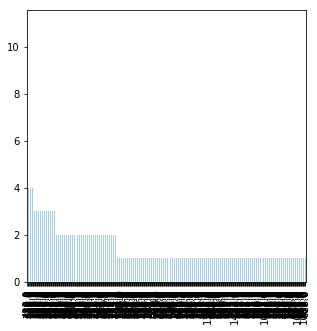

In [24]:
df[(df['totalCheeseClass']==1)]['kcal'].value_counts().plot('bar',figsize=(5,5),colormap="Paired")

In [25]:
df.columns

Index(['Recipe Url', 'Recipe Name', 'Preparation Time', 'Cooking Time',
       'Difficulty', 'Serves', 'Nutritional Info', 'Ingredients', 'Steps',
       'Additional Tags', 'cheddar', 'parmesan', 'cheese', 'totalCheese',
       'totalCheeseClass', 'intDiffi', 'newPrep', 'newCookT', 'totalTime',
       'timeBucket', 'time_Bucket', 'kcal', 'sugars', 'salt', 'carbs',
       'protein', 'fat', 'fibre', 'saturates'],
      dtype='object')

In [47]:
latestDF=df[['totalTime','totalCheese','protein','fat','fibre','saturates','salt','sugars','carbs','intDiffi','timeBucket']]

In [27]:
latestDF

,totalTime,totalCheese,protein,fat,fibre,saturates,salt,sugars,carbs,intDiffi,timeBucket
0,52.0,300.0,4.0,32.0,2.0,14.0,0.70,26.0,38.0,1,4
1,45.0,100.0,13.0,15.0,3.0,9.0,0.62,8.0,16.0,1,4
2,65.0,85.0,16.0,16.0,16.0,8.0,2.39,33.0,66.0,1,5
3,30.0,100.0,13.0,10.0,3.0,5.0,0.82,9.0,13.0,1,2
4,14.0,150.0,8.0,14.0,1.0,9.0,0.54,4.0,14.0,1,1
5,26.0,60.0,2.0,6.0,1.0,3.0,0.20,0.0,6.0,1,2
6,30.0,100.0,15.0,25.0,4.0,15.0,0.80,11.0,28.0,1,2
7,90.0,900.0,11.0,41.0,1.0,24.0,1.04,25.0,37.0,1,5
8,75.0,50.0,23.0,22.0,4.0,9.0,3.03,14.0,37.0,1,5
9,40.0,100.0,13.0,13.0,3.0,5.0,0.30,5.0,23.0,1,3


In [48]:
latestDF['cheeseCategory']=pd.qcut(latestDF['totalCheese'],4,labels=[1,2,3,4])
latestDF['cheese_Category']=pd.qcut(latestDF['totalCheese'],4,labels=["Less cheese","Moderate cheese","High Amount of cheese","TOO cheesy!"])
latestDF=latestDF.drop(columns=['totalCheese'])

In [49]:
len(latestDF.columns)

12

In [30]:
def additionalTags(tagArr):
    tagStr=' '.join(ast.literal_eval(tagArr))
    return tagStr
additionalTags("['Freezable','Easily halved','Vegetarian']")

'Freezable Easily halved Vegetarian'

In [50]:
df['Tag String']=df['Additional Tags'].apply(lambda atags: additionalTags(str(atags)))

In [51]:
df['Tag String']

0                                Can be frozen un-iced
1                                           Vegetarian
2                   Freezable Easily halved Vegetarian
3                    For up to 1 month, without cheese
4                                           Vegetarian
5                        Freezable Nut-free Vegetarian
6                                           Vegetarian
7                                            Freezable
8                                            Freezable
9                                 Freezable Vegetarian
10          Can be frozen when uncooked Easily doubled
11                  Easily doubled / halved Vegetarian
12                            Easily halved Vegetarian
13                    Can be frozen unbaked Vegetarian
14                                          Vegetarian
15                   Can be frozen uncooked Vegetarian
16                                                    
17                                           Freezable
18        

In [38]:
def isVege(tag):
    if "Vegetarian" in tag:
        return "Vegetarian"
    if tag=="":
        return "-1"
    return "Non-Vegetarian"
def isFrozen(tag):
    if "freezable" in tag.lower() or "frozen" in tag.lower():
        return "Frozen"
    if tag=="":
        return "-1"
    return "Not Frozen"

In [52]:
df['isVegetarian']=df['Tag String'].apply(lambda tagS: isVege(str(tagS)))

In [53]:
latestDF['isVegetarian']=df['isVegetarian']

In [54]:
df['isFrozen']=df['Tag String'].apply(lambda tagS: isFrozen(str(tagS)))
latestDF['isFrozen']=df['isFrozen']

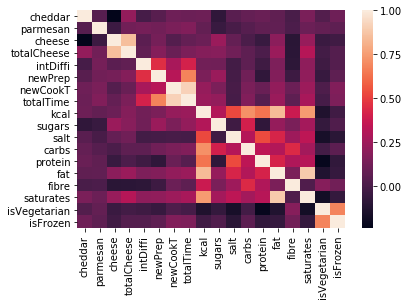

In [39]:
ax=sns.heatmap(df.corr())

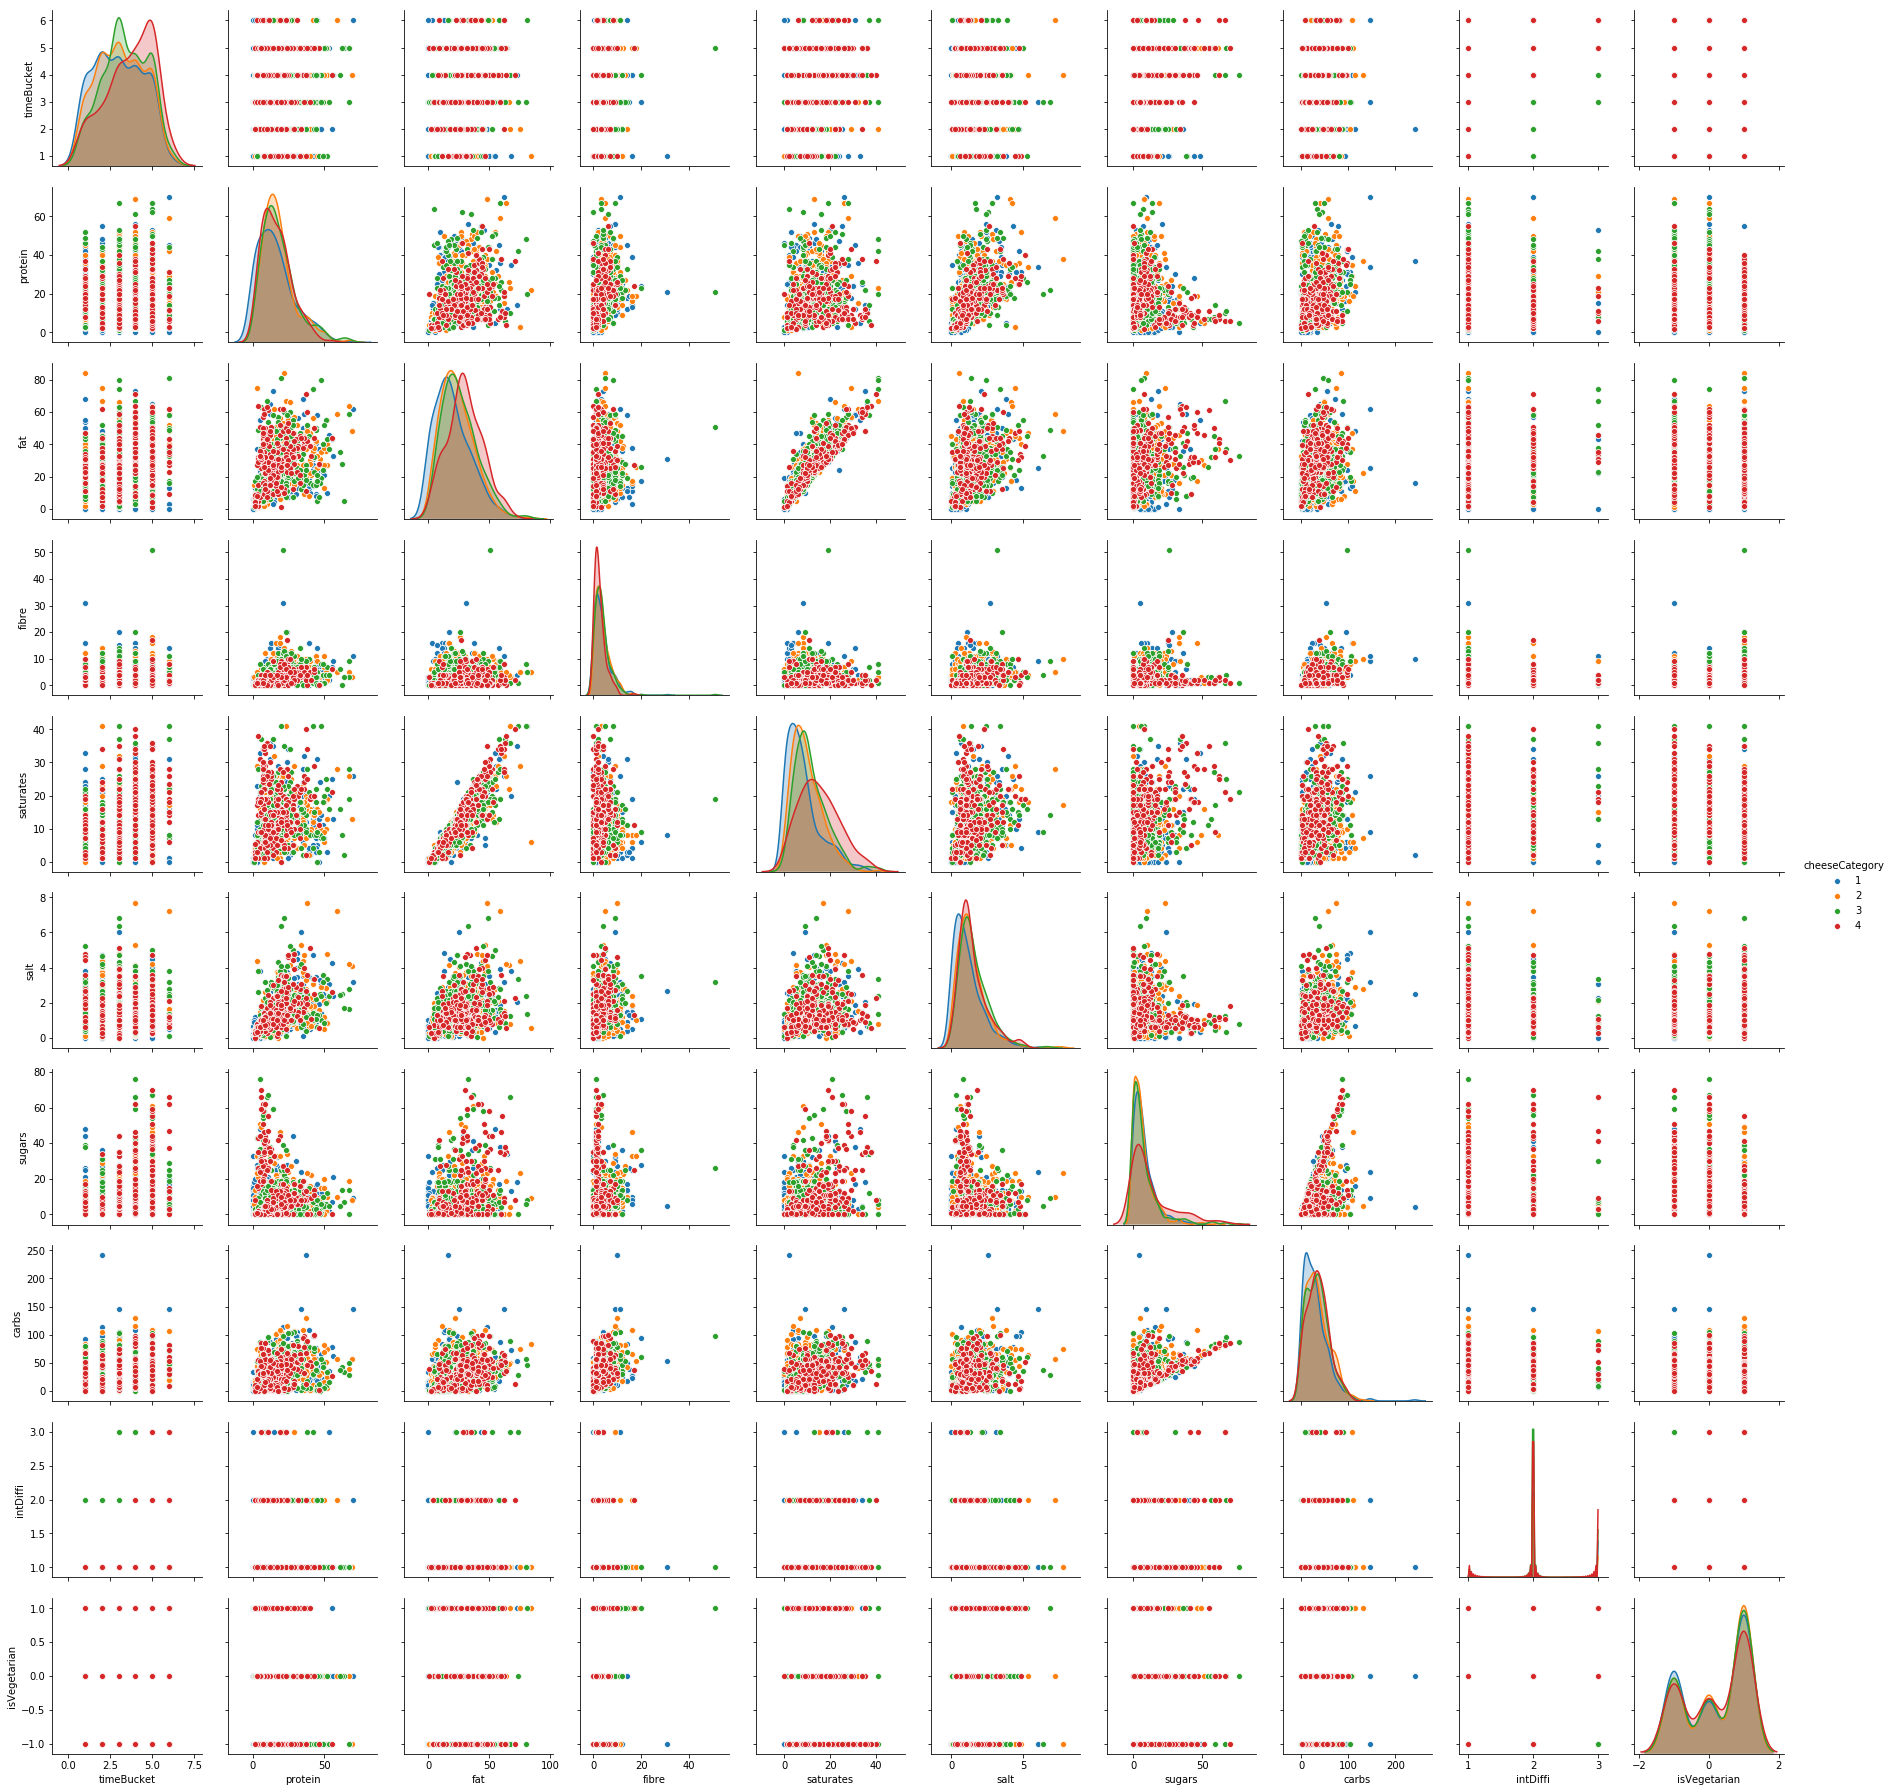

In [40]:
sns.pairplot(latestDF,vars=['timeBucket','protein','fat','fibre','saturates','salt','sugars','carbs','intDiffi','isVegetarian'],
            hue='cheeseCategory')

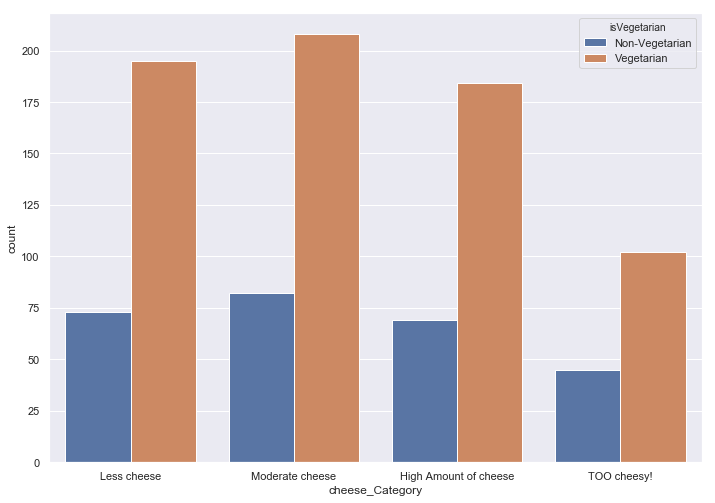

In [56]:
VegDF=latestDF[latestDF['isVegetarian']!="-1"]
sns.set(rc={'figure.figsize':(11.7,8.27)})
#VegDF['vegLabelled']=VegDF.apply(lambda veg: "Non-vegetarian" if veg==0 else "Vegetarian")
sns.countplot(x='cheese_Category',hue='isVegetarian',data=VegDF)

In [57]:
latestDF['isVegetarian'].value_counts()

Vegetarian        689
-1                377
Non-Vegetarian    269
Name: isVegetarian, dtype: int64

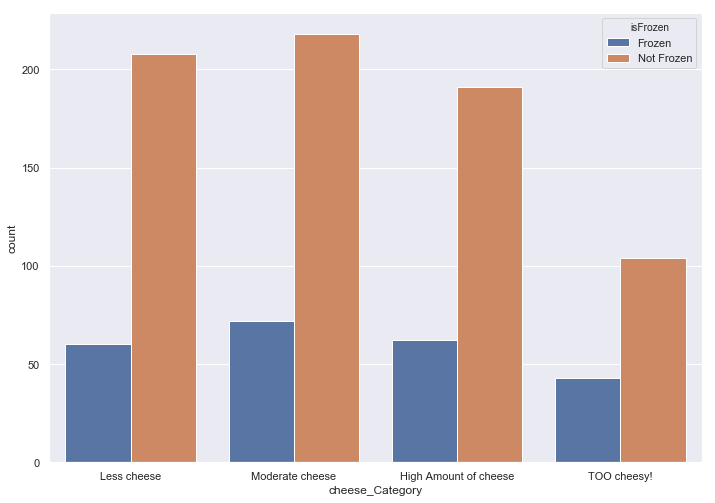

In [59]:
freDF=latestDF[latestDF['isFrozen']!="-1"]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='cheese_Category',hue='isFrozen',data=freDF)

In [60]:
latestDF['isFrozen'].value_counts()

Not Frozen    721
-1            377
Frozen        237
Name: isFrozen, dtype: int64

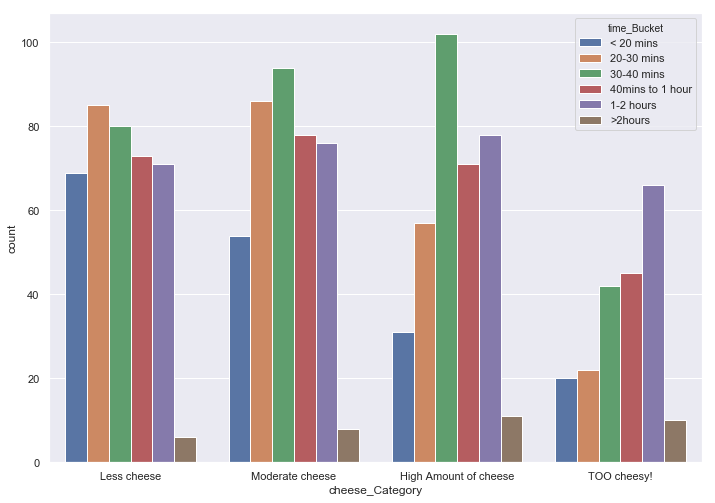

In [61]:
latestDF['time_Bucket']=df['time_Bucket']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='cheese_Category',hue='time_Bucket',data=latestDF)

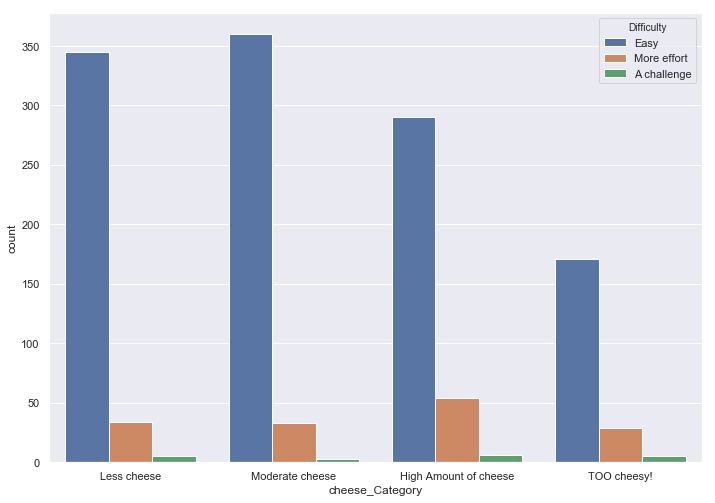

In [62]:
latestDF['Difficulty']=df['Difficulty']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='cheese_Category',hue='Difficulty',data=latestDF)

In [63]:
def serves(serve):
    s=re.fullmatch('[0-9][0-9]*',serve)
    if s is not None:
        return int(s[0])
    else:
        return 0

In [64]:
df['serveNum']=df['Serves'].apply(lambda serve: serves(str(serve)))

In [65]:
df=df.replace({'serveNum': {0: df['serveNum'].median()}}) 

In [66]:
df['serveNum'].describe()

count    1335.000000
mean        4.087640
std         2.542701
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max        28.000000
Name: serveNum, dtype: float64

In [67]:
latestDF['serveNum']=df['serveNum']

In [68]:
latestDF['serveCategory']=pd.cut(latestDF['serveNum'],bins=[0,2,7,29],labels=['Self/Pair','Family','Party'])

In [69]:
latestDF['serveCategory']

0          Family
1          Family
2          Family
3          Family
4          Family
5          Family
6          Family
7           Party
8          Family
9          Family
10      Self/Pair
11         Family
12         Family
13         Family
14         Family
15         Family
16         Family
17          Party
18         Family
19      Self/Pair
20         Family
21         Family
22         Family
23         Family
24         Family
25         Family
26          Party
27         Family
28         Family
29          Party
          ...    
1305       Family
1306       Family
1307    Self/Pair
1308       Family
1309       Family
1310       Family
1311        Party
1312       Family
1313       Family
1314       Family
1315       Family
1316       Family
1317       Family
1318       Family
1319       Family
1320       Family
1321       Family
1322        Party
1323       Family
1324       Family
1325        Party
1326        Party
1327       Family
1328        Party
1329      

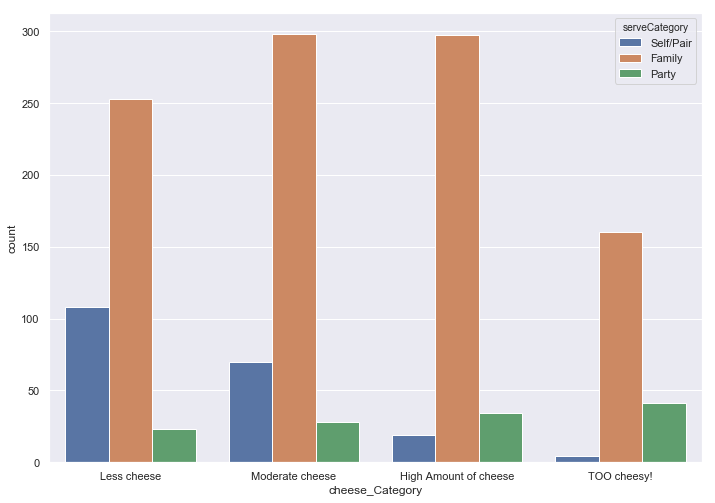

In [70]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='cheese_Category',hue='serveCategory',data=latestDF)

In [75]:
latestDF['FatForEach']=latestDF['fat']/latestDF['serveNum']

In [76]:
latestDF['FatForEach'].describe()

count    1335.000000
mean        7.664855
std         6.980273
min         0.000000
25%         3.333333
50%         6.000000
75%        10.000000
max        75.000000
Name: FatForEach, dtype: float64

In [77]:
latestDF["Fat_Category"]=pd.qcut(latestDF['FatForEach'],4,labels=['Low Fat','Moderate Fat','High Fat','A kilo in every bite'])

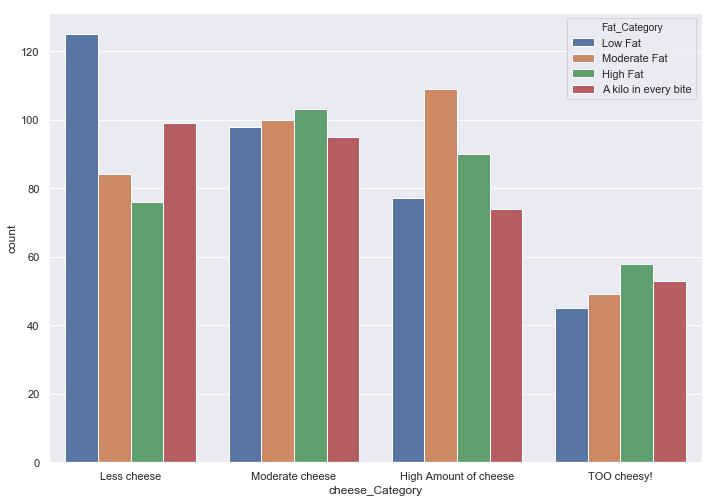

In [78]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='cheese_Category',hue='Fat_Category',data=latestDF)

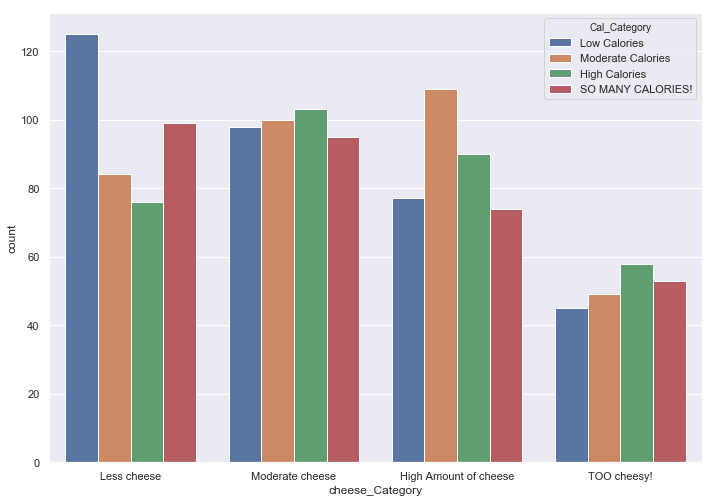

In [82]:
latestDF['kcal']=df['kcal']
latestDF['CalForEach']=latestDF['kcal']/latestDF['serveNum']
latestDF["Cal_Category"]=pd.qcut(latestDF['FatForEach'],4,labels=['Low Calories','Moderate Calories','High Calories','SO MANY CALORIES!'])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='cheese_Category',hue='Cal_Category',data=latestDF)

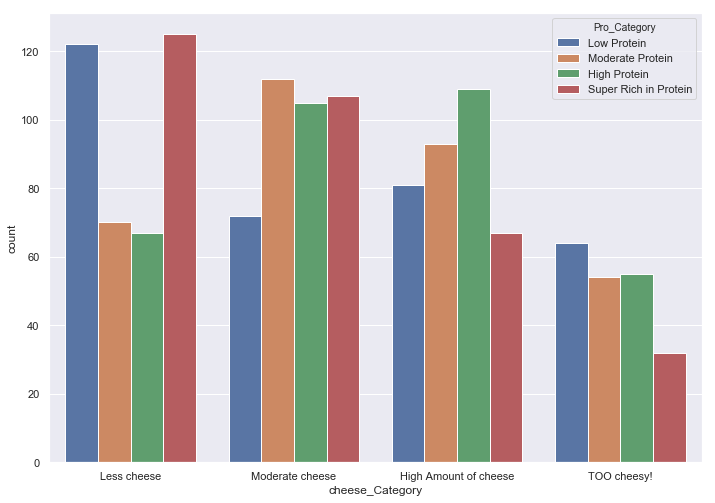

In [83]:
latestDF['ProForEach']=latestDF['protein']/latestDF['serveNum']
latestDF["Pro_Category"]=pd.qcut(latestDF['ProForEach'],4,labels=['Low Protein','Moderate Protein','High Protein','Super Rich in Protein'])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='cheese_Category',hue='Pro_Category',data=latestDF)

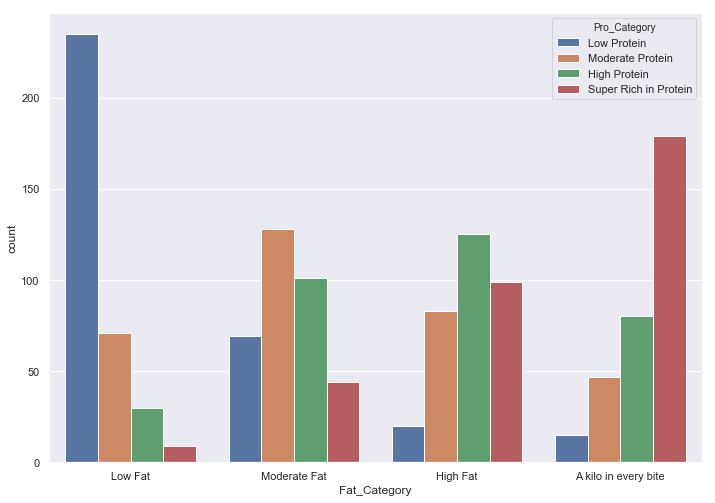

In [84]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='Fat_Category',hue='Pro_Category',data=latestDF)